# TP2 - Analyse Numérique - GMM4

In [30]:
import numpy as np
import numpy.linalg as npl
import scipy as sp
import scipy.linalg as spl
import matplotlib.pyplot as plt

Dans ce TP, on se propose d'implémenter l'algorithme QR que l'on a vu en cours en raffinant la méthode avec la mise sous forme Hessenberg.

## Implémentation de l'algorithme QR standard

On vous demande d'écrire une fonction `Eig_QR` qui implante l'algorithme QR suivant l'algorithme 1.8 de la page 27 du polycopié. Cet algorithme prendra la forme suivante:

$$
\left\{\begin{array}{ll}
A^{(0)} = A\in M_n(\mathbb{R}),\\
U^{(0)} = \textrm{Id},\\
\textrm{Pour }k=1,2,\cdots\\\left\{\begin{array}{ll}
Q^{(k)}R^{(k)} = A^{(k-1)},\\
A^{(k)} = R^{(k)}Q^{(k)},\\
U^{(k)} = Q^{(k)}U^{(k-1)}.\\
\end{array}\right.
\end{array}\right.
$$

On sait que la méthode QR va nous donner en réalité une décomposition de Schur de la matrice $A$. C'est-à-dire que la suite $A^{(k)}$ va tendre vers une matrice triangulaire supérieure $R$ et la suite $U^{(k)}$ va tendre vers une matrice orthogonale $Q$ telles que

$$
A = Q^{(k)}R^{(k)}Q^{(k)*}\to QRQ* = A.
$$

On aura donc accès aux valeurs propres de la matrice $A$ sur la diagonale de la matrice $R$.

En pratique, on utilisera, pour la factorisation QR, la méthode de Householder. On prendra le critère d'arrêt suivant:
$$
sup_{1\leq j\leq n} \frac{|A_{j,j}^{(k)}-A_{j,j}^{(k-1)}|}{|A_{j,j}^{(k-1)}|} < \varepsilon,
$$
où $\varepsilon>0$ est un paramètre que l'on fixe.

Vous prendrez en arguments d'entrée:
- M: la matrice dont on cherche les éléments propres,
- tol: la tolérance pour le test d'arrêt (que l'on prendra égal à $10^{-5}$ par défaut),
- itermax: le nombre maximal d'itérations (que l'on prendra égal à $100$ fois la taille de la matrice par défaut).

et en arguments de sortie:
- M: la matrice $A^{(k)}$,
- U: la matrice $U^{(k)}$,
- L: un vecteur contenant les valeurs propres calculées,
- niter: le nombre total d'itérations.

In [31]:
def  House(a):
    # Cette fonction calcule les donnees permettent de
    # definir la transformation elementaire qui envoie 
    # le vecteur f sur un vecteur parallele au premier 
    # vecteur de la base canonique.

    s =  np.sign(a[0])
    alpha = npl.norm(a)
    beta = alpha*(alpha + abs(a[0]))
    v1 = a[0] + s*alpha
    alpha = -s*alpha;
    return v1, beta, alpha

def MatQHouse(V, beta):
    sV = np.shape(V)
    Q = np.eye(sV[0],sV[1])
    for k in sorted(range(sV[1]),reverse=True):
        w = np.dot(V[range(k,sV[0]),k],Q[k:sV[0],k:sV[1]])/beta[k]
        Q[k:sV[0],k:sV[1]] -= np.outer(V[range(k,sV[0]), k],w)
    return Q

def TriangHouse(A):
    F = np.copy(A)
    sF = np.shape(F)
    beta  = np.zeros(sF[1])
    V = np.zeros(sF)
    v = np.zeros(sF[0])
    for k in range(sF[1]):
        v[k], beta[k], alpha = House(F[range(k,sF[0]),k])
        F[k,k] = alpha
        v[range(k+1,sF[0])] = F[range(k+1,sF[0]),k]
        F[k:sF[0],k+1:sF[1]] -= np.outer(v[range(k,sF[0])],np.dot(v[range(k,sF[0])],F[k:sF[0],k+1:sF[1]]))/beta[k]
        V[range(k,sF[0]),k] = v[range(k,sF[0])]
    R = np.triu(F) 
    return R[range(sF[1]),:], V, beta

def QR_House(A):
    R,V,beta = TriangHouse(A)
    return MatQHouse(V, beta),R

In [32]:
def Eig_QR(A,tol = 1e-5, itermax = None):
    n,m = np.shape(A)
    if itermax is None:
        itermax = 1000*n
    
    err = 2*tol
    Niter = 0
    U = np.eye(n)
    L_0 = np.zeros(n)
    while (err > tol) and (Niter < itermax) :
        Atemp = np.copy(A)
        Q,R = QR_House(Atemp)
        A = R.dot(Q)
        Utemp = np.copy(U)
        U = Q.dot(Utemp)
        L1 = np.diag(R)
        err =np.max(np.abs(L1-L_0)/np.abs(L1))
        Niter += 1
        L_0 = L1
        
    M = np.copy(A)
    return M,U,L_0,Niter

> **À faire:** Vous testerez cette fonction sur deux matrices aléatoires (symétrique et non symétrique) de taille $10$ et de valeurs propres $1,2,\ldots,10$ en fixant `itermax = 1, 3, 7, 100, 200` afin de suivre l'évolution de la matrice $A^{(k)}$. Que peut-on observer? Qu'observez vous quant à l'ordre des valeurs propres dans le vecteur `L`?

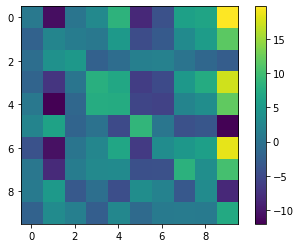

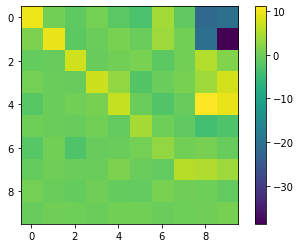

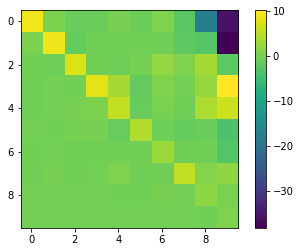

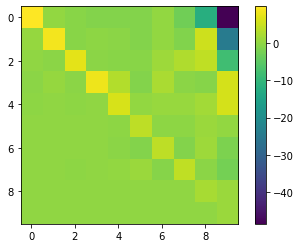

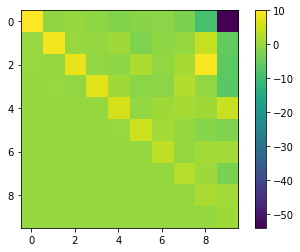

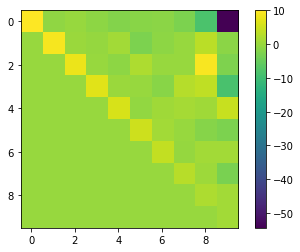

In [33]:
D = np.diag(np.array([1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]))
P = 2*(np.random.random((10,10))-0.5*np.ones((10,10)))
A = P.dot(D.dot(npl.inv(P)))
plt.imshow(A)
plt.colorbar()
plt.show()
for k in [1,3,7,20,100]:
    M,U,L,niter = Eig_QR(A,itermax = k)
    plt.imshow(M)
    plt.colorbar()
    plt.show()

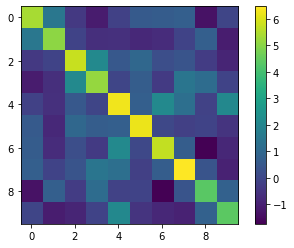

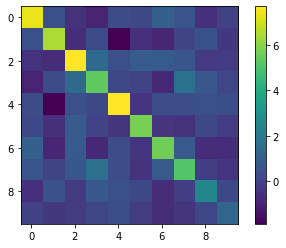

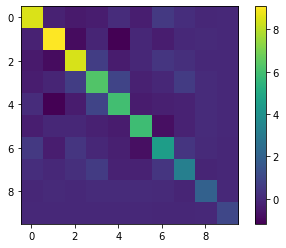

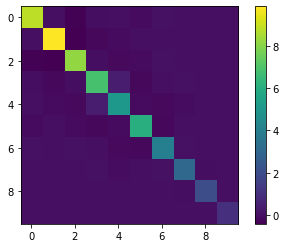

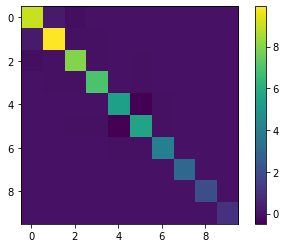

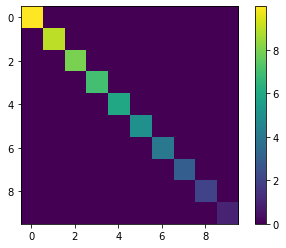

In [34]:
D = np.diag(np.array([1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]))
P = spl.orth(2*(np.random.random((10,10))-0.5*np.ones((10,10))))
A = P.dot(D.dot(npl.inv(P)))
plt.imshow(A)
plt.colorbar()
plt.show()
for k in [1,3,7,20,100]:
    M,U,L,niter = Eig_QR(A,itermax = k)
    plt.imshow(M)
    plt.colorbar()
    plt.show()

## Implémentation de la méthode QR avec mise sous forme de Hessenberg et rotations de Givens

Nous allons à présent améliorer la vitesse de la méthode QR en mettant au préalable la matrice dont on veut calculer les valeurs propres sous la forme de Hessenberg. Dans ce cadre, on sait que la suite de matrice $(A^{(k)})_{k\geq 0}$ donnée par la méthode QR sera aussi sous la forme de Hessenberg et un choix raisonnable pour la factorisation QR est alors d'utiliser les rotations de Givens.

On donne ci-dessous la fonction `HessenH`qui permet de mettre une matrice sous forme de Hessenberg à l'aide de la fonction `House` donnée plus haut. La fonction `HessenH` prend en argument d'entrée une matrice et renvoit en argument de sortie une matrice de Hessenberg ainsi qu'une matrice orthogonale.

In [35]:
def HessenH(M):
# Cette fonction revoit la factorisation M = Q H Q^T où 
# H est une matrice Hessenberg et Q une matrice orthogonale.
# La matrice H est donc semblable a la matrice M. 
# Cette fonction utilise la fonction
# House.
    n = np.shape(M)[0]
    Q = np.eye(n)
    for k in range(n-2):
        v, beta, alpha = House(M[k+1:n,k])
        w = np.zeros(n-k-1)
        w[0] = v
        w[1:n-1-k] = np.array(M[k+2:n,k])
        for P in [M,Q]:
            P[k+1:n,k:n] = P[k+1:n,k:n] - np.outer(w,np.dot(P[k+1:n,k:n].T,w)/beta)
            P[0:n,k+1:n] = P[0:n,k+1:n] - np.outer(P[0:n,k+1:n].dot(w),w/beta)
    return np.triu(M,-1),Q

On teste ci-dessous la fonction `HessenH` sur une matrice carré aléatoire non symétrique de taille 10.

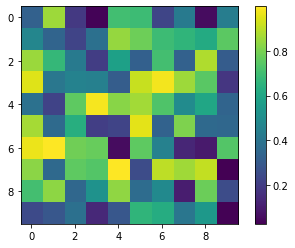

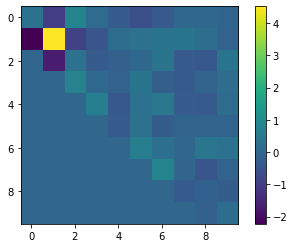

In [36]:
A = np.random.random((10,10))
plt.imshow(A)
plt.colorbar()
plt.show()
H,Q = HessenH(A)
plt.imshow(H)
plt.colorbar()
plt.show()

On se propose à présent d'implémenter un algorithme de factorisation QR par rotations de Givens spécifiquement pour les matrices de type Hessenberg. Ceci simplifie grandement la tâche puisqu'il ne faut éliminer qu'un seul terme par colonne. Plus précisément, on va avoir, pour une matrice $H\in M_n(\mathbb{R})$ de Hessenberg,

$$
\Omega_{n-1}\ldots\Omega_1 H = R,
$$

où $R\in M_n(\mathbb{R})$ est une matrice triangulaire supérieure. Les matrices de Givens $\Omega_k\in M_{n}(\mathbb{R})$ vont donc être de la forme

$$
\Omega_k = \begin{bmatrix}\textrm{Id}_{k-1} & 0 & 0 \\0 & \omega_k & 0\\ 0 & 0 & \textrm{Id}_{n - k - 1} \end{bmatrix},
$$
où $\omega_k$ est une matrice de rotation dans le plan de la forme

$$
\omega_k = \begin{bmatrix}
c_k & s_k \\ -s_k & c_k
\end{bmatrix},
$$

avec $c_k^2+s_k^2 = 1$, calculée de manière à annuler le coefficient de la sous-diagonale de la $k$-ième colonne. La matrice $Q$ de la factorisation QR de $H$ est alors donnée par

$$
Q = (\Omega_{n-1}\ldots\Omega_1)^T.
$$

On remarque qu'il est possible de calculer itérativement $Q$ de la manière suivante

$$
\left\{\begin{array}{ll}
U^{(1)} = \textrm{Id},
\\ U^{(k+1)} = \Omega_k U^{(k)},\quad\textrm{pour}\quad 1\leq k\leq n-1,
\\ Q = (U^{(n)})^T.
\end{array}\right.
$$

On propose donc l'algorithme suivant pour calculer la factorisation QR d'une matrice $H\in M_n(\mathbb{R})$ de type Hessenberg:

$$
\left\{\begin{array}{ll}
H^{(1)} = H,\\
U^{(1)} = \textrm{Id},\\
\textrm{Pour}\quad k = 1,2,\ldots,n-1:\\
\left\{\begin{array}{ll}
\textrm{Evaluer }\omega_k\textrm{ à partir de la }k\textrm{-ième colonne de }R^{(k)},\\
H^{(k+1)} = \Omega_k H^{(k)},\\
U^{(k+1)} = \Omega_k U^{(k)},
\end{array}\right.\\
R = H^{(n)},\\
Q = (U^{(n)})^T.
\end{array}\right.
$$

On remarque que l'on a pas réellement de calculer la matrice $\Omega_k$ dans l'algorithme précédent. Pour toute matrice $B\in M_n(\mathbb{R})$, le produit $C = \Omega_{k} B$ se fait en posant $C = B$ puis:

``
C[k,:] = c_k*B[k,:] + s_k*B[k+1,:]
C[k+1,:] = c_k*B[k+1,:] - s_k*B[k,:]
``

** Attention: faire des np.copy pour les tableaux!**

> **À faire:** Implémenter la fonction `QR_HessenH` qui met en oeuvre la factorisation QR d'une matrice de Hessenberg selon l'algorithme précédent. Elle prendra en entrée une matrice et donnera en sortie les matrices Q et R de la factorisation QR. On testera cette fonction sur une matrice aléatoire de type Hessenberg en vérifiant bien que l'on a $A =QR$.

In [37]:
def QR_HessenH(M):
    
    n,m = np.shape(M)
    H = HessenH(M)[0]
    U = np.eye(n)
    
    for i in range(0,n-1):
        c_k = H[i,i]/np.sqrt(H[i,i]**2+H[i+1,i]**2)
        s_k = H[i+1,i]/np.sqrt(H[i,i]**2+H[i+1,i]**2)
        
        Htemp = np.copy(H)
        H[i,:] = c_k*Htemp[i,:] + s_k*Htemp[i+1,:]
        H[i+1,:] = c_k*Htemp[i+1,:] - s_k*Htemp[i,:]
        Utemp = np.copy(U)
        U[i,:] = c_k*Utemp[i,:] + s_k*Utemp[i+1,:]
        U[i+1,:] = c_k*Utemp[i+1,:] - s_k*Utemp[i,:]
    
    R = np.copy(H)
    Q = U.T
    return Q,R

In [38]:
A = np.triu(np.random.random((10,10)),-1)
Q,R = QR_HessenH(A)
np.allclose(A,Q.dot(R))

True

> **À faire:** Implémenter la fonction `Eig_QR_HessenH` qui met en oeuvre la méthode QR avec mise sous forme de Hessenberg et factorisation QR à l'aide des rotations de Givens. Vous prendrez les mêmes arguments d'entrée et sortie que pour la fonction `Eig_QR`.

In [39]:
def Eig_QR_HessenH(A,tol = 1e-5, itermax = None):
    n,m = np.shape(A)
    if itermax is None:
        itermax = 1000*n
    
    err = 2*tol
    U = np.eye(n)
    Niter = 0
    H = HessenH(A)[0]
    L_0 = np.zeros(n)
    
    while (err > tol) and (Niter < itermax):
        Htemp = np.copy(H)
        Q,R = QR_HessenH(Htemp)
        H = R.dot(Q)
        U = Q.dot(U)
        L_1 = np.diag(H)
        err = max(np.abs(L_1-L_0)/np.abs(L_1))
        L_0 = L_1
        
    return H,U,L_0,Niter

> **À faire:** Vous testerez cette fonction sur une matrice aléatoire de taille $10$ et de valeurs propres $1,2,\ldots,10$ en fixant `itermax = 1, 3, 7, 100, 200` afin de suivre l'évolution de la matrice $A^{(k)}$. Que peut-on observer?

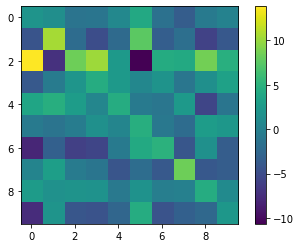

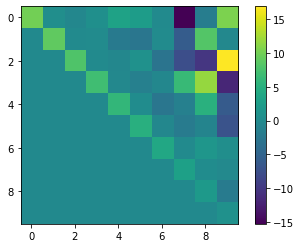

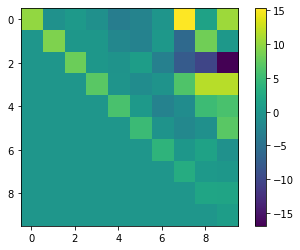

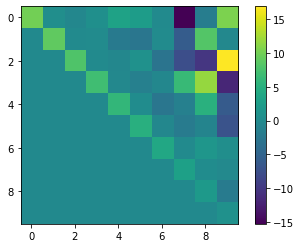

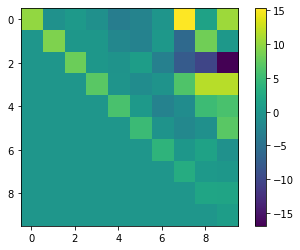

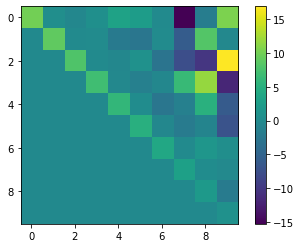

In [40]:
D = np.diag(np.array([1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]))
P = 2*(np.random.random((10,10))-0.5*np.ones((10,10)))
A = P.dot(D.dot(npl.inv(P)))
plt.imshow(A)
plt.colorbar()
plt.show()
for k in [1,3,7,20,100]:
    M,U,L,niter = Eig_QR_HessenH(A,itermax = k)
    plt.imshow(M)
    plt.colorbar()
    plt.show()

## Implémentation de la méthode QR avec mise sous forme de Hessenberg et translation

Nous allons à présent mettre en place les astuces vues en cours pour accélérer la convergence de la méthode QR. Dans le cadre de la méthode QR avec mise sous forme Hessenberg, on va mettre en place une stratégie de translation afin d'accélérer la convergence vers $0$ des coefficients de la sous-diagonale. L'algorithme est tiré du tableau 1.11 page 33 du polycopié. Il prend la forme suivante:

$$
\left\{\begin{array}{ll}
\textrm{Choix d'une translation }\mu,\\
\textrm{Mise sous forme Hessenberg } H = U^T A U,\\
H^{(0)} = H\in M_n(\mathbb{R}),\\
U^{(0)} = \textrm{Id},\\
\textrm{Pour }k=1,2,\cdots\\\left\{\begin{array}{ll}
Q^{(k)}R^{(k)} = H^{(k-1)} - \mu\textrm{Id},\\
H^{(k)} = R^{(k)}Q^{(k)} + \mu\textrm{Id},\\
U^{(k)} = Q^{(k)}U^{(k-1)}.\\
\end{array}\right.
\end{array}\right.
$$

> **À faire:** Implémenter la fonction `Eig_QR_HessenH_Tr` qui met en oeuvre la méthode QR avec mise sous forme de Hessenberg, factorisation QR à l'aide des rotations de Givens et translation de paramètre $\mu$. Vous prendrez les mêmes arguments d'entrée, avec en plus un scalaire représentant le paramètre de translation $\mu$, et sortie que pour la fonction `Eig_QR`.

In [42]:
def Eig_QR_HessenH_Tr(A, mu = 0, tol = 1e-5, itermax = None):
    n,m = np.shape(A)
    if itermax is None:
        itermax = 1000*n
   
    err = 2*tol
    U = np.eye(n)
    Niter = 0
    H = HessenH(A)[0]
    L_0 = np.zeros(n)
    
    while (err > tol) and (Niter < itermax):
        Htemp = np.copy(H)
        Q,R = QR_HessenH(H- mu*np.eye(n)) 
        H = R.dot(Q) + mu*np.eye(n)
        H = np.triu(H,-1)
        U = Q.dot(U)
        L_1 = np.diag(H)
        err = max(np.abs(L_1-L_0)/np.abs(L_1))
        L_0 = L_1
        
    
    return H,U,L_0,k

> **À faire:** Pour une matrices aléatoire de taille 10 dont le spectre est $\{1,2,\ldots,10\}$, on évalue le module des coefficients de la sous-diagonale de la matrice $H^{(k)}$ et l'erreur absolue sur les valeurs propres calculées en fonction de $k$. En testant plusieurs fois le script avec $\mu$ proche d'une valeur propre de votre choix:
- quel est le coefficient de la sous-diagonale qui converge le plus vite vers 0?
- quel est l'ordre des valeurs propres renvoyées par l'algorithme?
- ainsi, quelle est la valeur propre qui converge le plus vite?

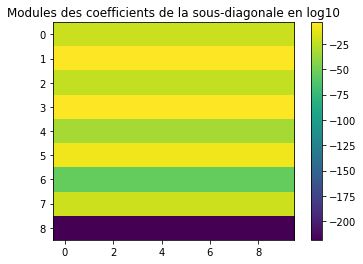

Valeurs propres calculées par l'algorithme:  [ 1.          1.9999905  10.0000095   3.00001348  8.99998652  4.
  8.          5.          7.          6.        ]


In [43]:
mu = 6.1

D = np.diag(np.array([1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]))
P = 2*(np.random.random((10,10))-0.5*np.ones((10,10)))
A = P.dot(D.dot(npl.inv(P)))
Dm1 = np.zeros((9,10))
for k in range(10):
    M,U,L,niter = Eig_QR_HessenH_Tr(A,mu,itermax = 10*(k+1))
    Dm1[:,k] = np.diag(M,-1)
plt.imshow(np.log10(abs(Dm1)))
plt.title("Modules des coefficients de la sous-diagonale en log10")
plt.colorbar()
plt.show()
M,U,L,niter = Eig_QR_HessenH_Tr(A,mu)
print("Valeurs propres calculées par l'algorithme: ",L)

## Implémentation de la méthode QR avec mise sous forme de Hessenberg, translation de Rayleigh et déflation

A la vue des résultats précédents, lors des itérations de la méthode QR, on voit qu'il peut être intéressant de déflater la matrice $H^{(k)}$ lorsque le dernier coefficient de la sous-diagonale de $H^{(k)}$ est suffisamment petit. A ce moment là, on arrête la boucle principale de la méthode, on stocke $H_{n,n}^{(k)}$ comme étant une approximation de valeur propre et on relance la méthode QR sur la sous-matrice de $H^{(k)}$ dont on a enlevé la dernière colonne et la dernière ligne. D'autre part, sachant que c'est le dernier coefficient qui s'annule, on peut appliquer la translation de Rayleigh en choisissant une translation qui évolue lors de l'algorithme

$$
\mu^{(k)} = H^{(k)}_{n,n}.
$$

On obtient alors l'algorithme suivant qui est similaire à celui du tableau 1.12 page 35 du polycopié:

$$
\left\{\begin{array}{ll}
\textrm{Choix d'une translation }\mu,\\
\textrm{Mise sous forme Hessenberg } H = U^T A U,\\
H^{(0)} = H\in M_n(\mathbb{R}),\\
U^{(0)} = \textrm{Id},\\
\textrm{Pour }k=1,2,\cdots\\\left\{\begin{array}{ll}
\mu^{(k)} = H^{(k)}_{n,n},\\
Q^{(k)}R^{(k)} = H^{(k-1)} - \mu^{(k)}\textrm{Id},\\
H^{(k)} = R^{(k)}Q^{(k)} + \mu^{(k)}\textrm{Id},\\
\textrm{Si }H^{(k)}_{n,n-1} < \varepsilon :\\\left\{\begin{array}{ll}
\mu^{(k)}\textrm{ est l'approximation d'une valeur propre,}\\
\textrm{Arrêt de la boucle sur }k\textrm{ et relance de l'algorithme sur la sous-matrice }H^{(k)}_{(n-1,n-1)},
\end{array}\right.
\end{array}\right.
\end{array}\right.
$$

Le critère d'arrêt est donc fixé, implicitement, à partir du dernier coefficient de la sous-diagonale. On remarque aussi que, lorsque la sous-matrice $H^{(k)}_{(n-1,n-1)}$ est un scalaire, on arrête totalement l'algorithme.

> **À faire:** Implémenter la fonction `Eig_QR_Rayleigh` qui met en oeuvre la méthode QR avec mise sous forme de Hessenberg, factorisation QR à l'aide des rotations de Givens, translation de Rayleigh et déflation. Vous prendrez les mêmes arguments d'entrée pour la fonction `Eig_QR` mais uniquement le nombre total d'itérations et les valeurs propres en sortie.

In [ ]:
def Eig_QR_Rayleigh(A, tol = 1e-5, itermax = None):
    n,m = np.shape(A)
    if itermax is None:
        itermax = 1000*n
    return L,k

> **À faire:** Pour une matrices aléatoire de taille 100 dont le spectre est $\{1,2,\ldots,100\}$ et en moyennant sur une vingtaine de réalisations, vous comparerez le nombre total d'itérations nécessaires à la convergence de l'algorithme QR standard et celui avec déflation. Quelle conclusion en tirez vous?

In [ ]:
N = 20
n = 50
niter = np.zeros((2,N))
for k in range(N):
    D = np.diag(np.array(range(1,n+1)))
    P = 2*(np.random.random((n,n))-0.5*np.ones((n,n)))
    A = P.dot(D.dot(npl.inv(P)))
    niter[0,k] = Eig_QR(A)[3]
    niter[1,k] = Eig_QR_Rayleigh(A)[1]
plt.plot(niter[0,:], label = 'QR standard')
plt.plot(niter[1,:], label = 'QR avec déflation')
plt.title("Nombre d'itérations pour converger")
plt.legend()
plt.show()

> **À faire:** Pour finir, proposer une amélioration pour la méthode QR avec déflation afin d'accélérer encore l'algorithme. Implémenter votre nouvelle méthode et tester le gain en itérations.

In [ ]:
def Eig_QR_Defla(A, tol = 1e-5, itermax = None):
    n,m = np.shape(A)
    if itermax is None:
        itermax = 1000*n
    return L,k

In [ ]:
n = 100
D = np.diag(np.array(range(1,n+1)))
P = 2*(np.random.random((n,n))-0.5*np.ones((n,n)))
A = P.dot(D.dot(npl.inv(P)))
L,niter = Eig_QR_Rayleigh(A)
print(niter)
L,niter = Eig_QR_Defla(A)
print(niter)